In [17]:
#velocity reconstruction: for single smoothing scale, vlin_interp removed from data channel, separated baseline for linear theory comparison
# cnn input: density, position, halo mass
import os, time, random
import numpy as np, h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import RegularGridInterpolator
from numpy.fft import fftn, ifftn, fftfreq

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split


In [18]:
GRID_FILE = "Grids_Mcdm_IllustrisTNG_1P_128_z=0.0.npy"
TRAIN_HALO_FILE = "groups_090_1P_0.hdf5"
TEST_HALO_FILE  = "groups_090_1P_p2_n1.hdf5"   
TRAIN_REAL_IDX = 0
TEST_REAL_IDX = 14

PATCH = 32
BATCH = 16           
EPOCHS = 60
LR = 1e-4
WEIGHT_DECAY = 1e-5
MASS_CUT = 1e11
BOXSIZE = 25.0
MAX_HALOS = 5000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUGMENT = True
PATIENCE = 14
SMOOTH_SCALE = 2.0
CHECKPOINT_DIR = "checkpoints_no_vlin_improved_v2"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
SEED = 42
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# pearson penalty weight (try 0.01 - 0.2)
PEARSON_WEIGHT = 0.08

# test-time augmentation toggle (flip x/y)
TTA = True

print("Device:", DEVICE)


Device: cuda


In [2]:
def memmap_grid_slices(grid_file, idxs):
    if isinstance(idxs, int): idxs = [idxs]
    arr = np.load(grid_file, allow_pickle=False, mmap_mode='r')
    return [np.asarray(arr[i], dtype=np.float32) for i in idxs]

In [3]:
def load_halos(hfile):
    with h5py.File(hfile, "r") as f:
        pos = np.array(f["Group/GroupPos"]) / 1000.0  # ckpc/h -> Mpc/h
        vel = np.array(f["Group/GroupVel"])
        mass = np.array(f["Group/Group_M_Mean200"]) * 1e10
    return pos, vel, mass


In [4]:
def smooth_density_kspace(rho_cdm, R_smooth, boxsize=BOXSIZE):
    rho = np.asarray(rho_cdm, dtype=np.float32)
    delta = rho / rho.mean() - 1.0
    if R_smooth == 0.0:
        return delta.astype(np.float32)
    N = rho.shape[0]
    dk = fftn(delta)
    kfreq = fftfreq(N, d=boxsize/N)
    kx, ky, kz = np.meshgrid(2*np.pi*kfreq, 2*np.pi*kfreq, 2*np.pi*kfreq, indexing='ij')
    k2 = kx**2 + ky**2 + kz**2
    W = np.exp(-0.5 * k2 * (R_smooth**2))
    return ifftn(dk * W).real.astype(np.float32)

In [5]:
def compute_vlin_from_density(rho_cdm, z_snap=0.0, boxsize=BOXSIZE,
                              H0=67.66, Omega_m0=0.3, R_smooth=2.0):
    N = rho_cdm.shape[0]
    a = 1.0 / (1.0 + z_snap)
    Hz = H0 * np.sqrt(Omega_m0 * (1+z_snap)**3 + 1.0 - Omega_m0)
    f = (Omega_m0*(1+z_snap)**3 / (Omega_m0*(1+z_snap)**3 + 1.0 - Omega_m0))**0.55
    delta_x = rho_cdm / np.mean(rho_cdm) - 1.0
    dk = fftn(delta_x)
    kfreq = fftfreq(N, d=boxsize/N)
    kx, ky, kz = np.meshgrid(2*np.pi*kfreq, 2*np.pi*kfreq, 2*np.pi*kfreq, indexing='ij')
    k2 = kx**2 + ky**2 + kz**2
    k2_nozero = np.where(k2 == 0, 1.0, k2)
    pref = 1j * a * Hz * f
    vz_k = pref * (kz / k2_nozero) * dk
    vz_k[k2 == 0] = 0.0
    if R_smooth is not None and R_smooth > 0.0:
        W = np.exp(-0.5 * k2 * (R_smooth**2))
        vz_k *= W
    vz_x = ifftn(vz_k).real
    return vz_x.astype(np.float32)

In [6]:
def build_vlin_interpolator(vlin_grid):
    N = vlin_grid.shape[0]
    cell = BOXSIZE / N
    coords = (np.arange(N) + 0.5) * cell
    return RegularGridInterpolator((coords, coords, coords), vlin_grid,
                                   bounds_error=False, fill_value=0.0)


In [7]:
# preparing dataset to extract 3D density patch from grids, add coordinates, augment by symmetry operation
# returns the patch together with normalized halo mass and the line-of-sight velocity.

class MultiChannelHaloDataset(Dataset):
    
    def __init__(self, grids_channels, pos, vel, mass,
                 mass_mean=None, mass_std=None,
                 mass_cut=MASS_CUT, max_n=MAX_HALOS,
                 augment=AUGMENT, rng=None):

        if rng is None:
            rng = np.random.RandomState(SEED)
        # Select halos above mass threshold
        mask = mass > mass_cut
        pos, vel, mass = pos[mask], vel[mask], mass[mask]

        # Deterministic subsampling for reproducibility
        if max_n is not None and len(pos) > max_n:
            sel = rng.choice(len(pos), max_n, replace=False)
            pos, vel, mass = pos[sel], vel[sel], mass[sel]
        # store extracted data
        self.pos  = pos
        self.vz   = vel[:, 2].astype(np.float32)
        self.mass = mass.astype(np.float32)

        self.grids   = grids_channels
        self.N       = grids_channels[0].shape[0]
        self.patch   = PATCH
        self.augment = augment

        # Train-based mass normalization
        logm = np.log10(self.mass + 1e-12)
        self.mass_mean = mass_mean if mass_mean is not None else logm.mean()
        self.mass_std  = mass_std  if mass_std  is not None else logm.std() + 1e-12

        print(f"Selected {len(self.pos)} halos (mass_cut={mass_cut}, cap={max_n}).")

    def __len__(self):
        return len(self.pos)

    def _extract_patch_single(self, grid, center):
        #Extract periodic cubic patch centered on halo
        cell = BOXSIZE / self.N
        idx  = (center / cell - 0.5).astype(int)
        r    = self.patch // 2

        xs = [(idx[0] + i) % self.N for i in range(-r, r)]
        ys = [(idx[1] + i) % self.N for i in range(-r, r)]
        zs = [(idx[2] + i) % self.N for i in range(-r, r)]

        return grid[np.ix_(xs, ys, zs)]

    def __getitem__(self, i):
        # Extract density patches
        patches = [self._extract_patch_single(g, self.pos[i]) for g in self.grids]

        # Relative coordinate channels in [-1,1]
        P = self.patch
        coords = (np.arange(P) - (P - 1)/2) / ((P - 1)/2)
        X, Y, Z = np.meshgrid(coords, coords, coords, indexing="ij")

        x = np.stack(patches + [X, Y, Z], axis=0).astype(np.float32)
        x = np.clip(x, -6.0, 6.0)

        # Symmetry augmentation
        if self.augment:
            if np.random.rand() < 0.5: x = x[:, ::-1, :, :]
            if np.random.rand() < 0.5: x = x[:, :, ::-1, :]
            k = np.random.randint(4)
            if k: x = np.rot90(x, k, axes=(1, 2))

        # Scalar halo mass feature
        mass_norm = (np.log10(self.mass[i] + 1e-12) - self.mass_mean) / self.mass_std
        # cnn output
        y = float(self.vz[i])
        return np.ascontiguousarray(x, dtype=np.float32), np.float32(mass_norm), np.float32(y)


In [8]:
def conv3d_gn(in_ch, out_ch, kernel=3, stride=1, padding=1, ngroups=8):
    g = min(ngroups, out_ch)
    while out_ch % g != 0 and g > 1:
        g -= 1
    return nn.Sequential(
        nn.Conv3d(in_ch, out_ch, kernel_size=kernel, stride=stride,
                  padding=padding, bias=False),
        nn.GroupNorm(num_groups=g, num_channels=out_ch),
        nn.ReLU(inplace=True)
    )

In [9]:
class ResidualBlock3D(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv3d(ch, ch, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups=min(8, ch), num_channels=ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(ch, ch, kernel_size=3, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(num_groups=min(8, ch), num_channels=ch)

    def forward(self, x):
        out = self.conv1(x); out = self.gn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.gn2(out)
        return self.relu(out + x)


In [10]:
class CNN_Improved3D(nn.Module):
    def __init__(self, in_ch=4, base_ch=40, dropout=0.15, n_blocks=2):
        super().__init__()
        self.conv_in = conv3d_gn(in_ch, base_ch)
        self.down1 = nn.Sequential(
            nn.MaxPool3d(2),
            conv3d_gn(base_ch, base_ch * 2)
        )
        self.res1 = nn.Sequential(
            *[ResidualBlock3D(base_ch * 2) for _ in range(n_blocks)]
        )
        self.down2 = nn.Sequential(
            nn.MaxPool3d(2),
            conv3d_gn(base_ch * 2, base_ch * 4)
        )
        self.res2 = nn.Sequential(
            *[ResidualBlock3D(base_ch * 4) for _ in range(n_blocks)]
        )
        self.avgpool = nn.AdaptiveAvgPool3d(1)
        feat = base_ch * 4
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat + 1, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.GroupNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, mass_scalar):
        x = self.conv_in(x)
        x = self.down1(x)
        x = self.res1(x)
        x = self.down2(x)
        x = self.res2(x)
        f = self.avgpool(x).view(x.size(0), -1)

        if not torch.is_tensor(mass_scalar):
            mass_scalar = torch.tensor(mass_scalar, dtype=f.dtype, device=f.device)
        if mass_scalar.dim() == 1:
            ms = mass_scalar.view(x.size(0), 1)
        else:
            ms = mass_scalar.view(x.size(0), -1)
        ms = ms.to(f.dtype).to(f.device)

        cat = torch.cat([f, ms], dim=1)
        out = self.head(cat).view(-1)
        return out

In [11]:
def pearson_corr_torch(x, y, eps=1e-6):
    # x, y: tensors (batch,)
    xm = torch.mean(x)
    ym = torch.mean(y)
    xm0 = x - xm
    ym0 = y - ym
    cov = torch.mean(xm0 * ym0)
    sx = torch.sqrt(torch.mean(xm0 * xm0) + eps)
    sy = torch.sqrt(torch.mean(ym0 * ym0) + eps)
    corr = cov / (sx * sy + eps)
    return corr

In [12]:
def _compute_stats(true, pred):
    mask = np.isfinite(true) & np.isfinite(pred)
    n = int(mask.sum())
    if n == 0:
        return mask, np.nan, np.nan, np.nan, np.nan, np.nan, n
    t = true[mask]; p = pred[mask]
    try:
        corr = float(pearsonr(t, p)[0])
    except Exception:
        corr = np.nan
    bias = float(np.mean(p - t))
    rmse = float(np.sqrt(np.mean((p - t) ** 2)))
    rms_true = float(np.std(t))
    rms_pred = float(np.std(p))
    return mask, corr, bias, rmse, rms_true, rms_pred, n

In [13]:
def hexbin_panel(ax, true, pred, title, cmap="viridis"):
    mask, corr, bias, rmse, rms_true, rms_pred, n = _compute_stats(true, pred)
    vmax = max(np.max(np.abs(true[mask])), np.max(np.abs(pred[mask]))) if n > 0 else 1.0
    lims = [-vmax, vmax]

    hb = ax.hexbin(
        true[mask], pred[mask],
        gridsize=150,
        cmap=cmap,
        bins='log',
        mincnt=1,
        extent=(lims[0], lims[1], lims[0], lims[1])
    )

    ax.plot(lims, lims, 'r--', lw=1.2, label="1:1")
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("True LOS velocity (km/s)")
    ax.set_ylabel("Predicted LOS velocity (km/s)")
    ax.set_title(f"{title}\nρ = {corr:.3f}")

    stats_text = (
        f"N = {n}\n"
        f"ρ = {corr:.3f}\n"
        f"Bias = {bias:.2f}\n"
        f"RMSE = {rmse:.2f}\n"
        f"RMS(true) = {rms_true:.2f}\n"
        f"RMS(pred) = {rms_pred:.2f}"
    )

    ax.text(
        0.02, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=9,
        va='top',
        bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.85)
    )
    return hb

In [14]:
def vlin_at_halos(vlin_grid, halo_pos):
    """Interpolate linear-theory vz field at halo positions."""
    interp = build_vlin_interpolator(vlin_grid)
    pos_wrapped = (halo_pos % BOXSIZE)
    vals = [np.asarray(interp(tuple(p))).item() for p in pos_wrapped]
    return np.array(vals, dtype=np.float32)

In [15]:
def train_and_eval():
   
    # ---------- 1. Grids & multi-scale density channels ----------
    grid_train, grid_test = memmap_grid_slices(GRID_FILE, [TRAIN_REAL_IDX, TEST_REAL_IDX])
    print("Grid shapes (train, test):", grid_train.shape, grid_test.shape)

    print("Building multi-scale overdensity channels...")
    channels_train_raw = [ smooth_density_kspace(grid_train, SMOOTH_SCALE)]
    channels_test_raw  = [ smooth_density_kspace(grid_test,  SMOOTH_SCALE) ]
   
    # ---------- 2. Channel-wise normalization ----------
    a_train = np.asarray(channels_train_raw[0], dtype=np.float32)
    am, ast = float(a_train.mean()), float(a_train.std()) + 1e-12
    train_ch_stats = [(am, ast)]
    channels_train = [ ((a_train - am) / ast).astype(np.float32) ]

    a_test = np.asarray(channels_test_raw[0], dtype=np.float32)
    channels_test = [ ((a_test - am) / ast).astype(np.float32) ]

    # ---------- 3. Halos ----------
    pos_tr, vel_tr, mass_tr = load_halos(TRAIN_HALO_FILE)
    pos_te, vel_te, mass_te = load_halos(TEST_HALO_FILE)
    print("Loaded halos (train, test):", len(pos_tr), len(pos_te))


    # ---------- 4. Mass normalization (for halo mass feature) ----------
    mass_log_tr = np.log10(mass_tr[mass_tr > MASS_CUT] + 1e-12)
    if len(mass_log_tr) == 0:
        # Fallback: auto-rescale mass if MASS_CUT is huge relative to values
        scales = [1.0, 1e10, 1e12]
        chosen_scale = 1.0
        for s in scales:
            if np.sum(mass_tr * s >= 1e11) > 0:
                chosen_scale = s
                break
        mass_tr = mass_tr * chosen_scale
        mass_te = mass_te * chosen_scale
        mass_log_tr = np.log10(mass_tr[mass_tr > MASS_CUT] + 1e-12)
        print(f"Auto-scaled mass by {chosen_scale:.0e}")

    mass_mean = float(np.mean(mass_log_tr)) if len(mass_log_tr) > 0 else 0.0
    mass_std  = float(np.std(mass_log_tr)) + 1e-12
    print("mass_log mean/std (used):", mass_mean, mass_std)

    # ---------- 5. Datasets ----------
    # Each dataset item returns: (x_patch, mass_scalar, v_z_true)
    rng = np.random.RandomState(SEED)
    train_ds_full = MultiChannelHaloDataset(
        channels_train, pos_tr, vel_tr, mass_tr,
        mass_mean=mass_mean, mass_std=mass_std,
        mass_cut=MASS_CUT, max_n=MAX_HALOS,
        augment=AUGMENT, rng=rng
    )
    test_ds = MultiChannelHaloDataset(
        channels_test, pos_te, vel_te, mass_te,
        mass_mean=mass_mean, mass_std=mass_std,
        mass_cut=MASS_CUT, max_n=MAX_HALOS,
        augment=False, rng=rng
    )

     #----------v_lin baseline------------ 
    print("Computing v_lin baseline (on CNN test halos)...")
    vlin_test = compute_vlin_from_density(grid_test, R_smooth=2.0)
    vlin_baseline = vlin_at_halos(vlin_test, test_ds.pos)   # uses mass-cut sample
    v_true_test   = test_ds.vz                              # same sample

    try:
        rho_vlin = pearsonr(v_true_test, vlin_baseline)[0]
    except Exception:
        rho_vlin = np.nan
    print(f"ρ (v_lin baseline, mass-cut halos) = {rho_vlin:.4f}")

    # ---------- 6. Train / validation split ----------
    idxs = np.arange(len(train_ds_full))
    tr_idx, val_idx = train_test_split(idxs, test_size=0.2, random_state=SEED)

    y_list = [train_ds_full[i][2] for i in tr_idx]  # v_z for training halos
    y_arr  = np.array(y_list, dtype=np.float32)
    y_mean = float(y_arr.mean())
    y_std  = float(y_arr.std() + 1e-12)
    print("Train v_z mean/std:", y_mean, y_std)

    tr_ds = Subset(train_ds_full, tr_idx)
    val_ds = Subset(train_ds_full, val_idx)

    tr_loader = DataLoader(tr_ds, batch_size=BATCH, shuffle=True,  num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)
    te_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0)

    # ---------- 7. CNN model: inputs & output summary ----------
    in_ch = 1 + 3  # density channel + 3 coords (x,y,z)
    print(
        f"\nCNN setup:"
        f"\n  • Input x_patch: C={in_ch} channels (densities + coords)"
        f"\n  • Input mass_s:  1D halo mass feature"
        f"\n  • Output:        line-of-sight velocity v_z\n"
    )

    model = CNN_Improved3D(in_ch=in_ch, base_ch=40, dropout=0.15, n_blocks=2).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=6, min_lr=1e-6
    )
    loss_fn = nn.SmoothL1Loss()

    best_val   = np.inf
    best_epoch = -1
    no_improve = 0
    best_ckpt_fixed = os.path.join(CHECKPOINT_DIR, "cnn_best.pth")

    # ---------- 8. Training loop ----------
    first_batch_shown = False  # for a one-time shape print

    for epoch in range(EPOCHS):
        t0 = time.time()
        model.train()

        train_losses = []
        train_preds  = []
        train_trues  = []

        for xb, mass_s, y in tr_loader:
            # xb:      [B, C, Dx, Dy, Dz]
            # mass_s:  [B] or [B, 1] (halo mass feature)
            # y:       [B] true v_z
            xb     = xb.to(DEVICE)
            mass_s = mass_s.to(DEVICE)
            y      = torch.as_tensor(y, device=DEVICE)

            if y.dim() == 2 and y.size(1) == 1:
                y = y.view(-1)

            # One-time visual summary of a batch
            if not first_batch_shown:
                print("Example batch:")
                print("  xb shape     :", xb.shape, "(density+coords patch)")
                print("  mass_s shape :", mass_s.shape, "(halo mass feature)")
                print("  y shape      :", y.shape, "(true v_z)\n")
                first_batch_shown = True

            # Normalize targets for stable training
            y_n = (y - y_mean) / y_std

            # CNN prediction in normalized v_z space
            pred_n = model(xb, mass_s)
            base_loss = loss_fn(pred_n, y_n)

            # Pearson penalty on *denormalized* v_z (matches our final metric)
            pred_den  = pred_n * y_std + y_mean
            true_den  = y
            p         = pearson_corr_torch(pred_den, true_den)
            pearson_loss = 1.0 - p          # push ρ → 1
            loss         = base_loss + PEARSON_WEIGHT * pearson_loss

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

            train_losses.append(loss.item() * xb.size(0))
            train_preds.append(pred_den.detach().cpu().numpy().reshape(-1))
            train_trues.append(y.cpu().numpy().reshape(-1))

        train_loss = np.sum(train_losses) / len(tr_ds) if len(tr_ds) > 0 else np.nan
        train_preds = np.concatenate(train_preds) if train_preds else np.array([])
        train_trues = np.concatenate(train_trues) if train_trues else np.array([])

        try:
            train_rho = pearsonr(train_trues, train_preds)[0]
        except Exception:
            train_rho = np.nan

        # ---------- 9. Validation ----------
        model.eval()
        val_losses = []
        val_preds  = []
        val_trues  = []

        with torch.no_grad():
            for xb, mass_s, y in val_loader:
                xb     = xb.to(DEVICE)
                mass_s = mass_s.to(DEVICE)
                y      = torch.as_tensor(y, device=DEVICE)

                if y.dim() == 2 and y.size(1) == 1:
                    y = y.view(-1)

                pred_n   = model(xb, mass_s)
                pred_den = pred_n * y_std + y_mean

                val_preds.append(pred_den.cpu().numpy().reshape(-1))
                val_trues.append(y.cpu().numpy().reshape(-1))

                # MSE in normalized space, aggregated by sample count
                val_losses.append(((pred_n - (y - y_mean) / y_std) ** 2).mean().item() * xb.size(0))

        val_preds = np.concatenate(val_preds) if val_preds else np.array([])
        val_trues = np.concatenate(val_trues) if val_trues else np.array([])
        val_loss  = np.sum(val_losses) / len(val_ds) if len(val_ds) > 0 else np.nan

        try:
            val_rho = pearsonr(val_trues, val_preds)[0]
        except Exception:
            val_rho = np.nan

        scheduler.step(val_loss)
        dt = time.time() - t0

        print(
            f"Epoch {epoch+1}/{EPOCHS}  "
            f"TrainLoss={train_loss:.3e}  ρ_train={train_rho:.3f}  |  "
            f"ValLoss={val_loss:.3e}  ρ_val={val_rho:.3f}  |  {dt:.1f}s"
        )

        # Early-stopping logic
        if np.isfinite(val_loss) and val_loss < best_val - 1e-9:
            best_val   = val_loss
            best_epoch = epoch + 1
            no_improve = 0

            ckpt_path = os.path.join(CHECKPOINT_DIR, f"cnn_best_epoch{best_epoch}.pth")
            payload = {
                "model_state_dict": model.state_dict(),
                "y_mean": y_mean,
                "y_std":  y_std,
            }
            torch.save(payload, ckpt_path)
            torch.save(payload, best_ckpt_fixed)
            print("Saved checkpoint:", ckpt_path)
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print("Early stopping (no val improvement).")
                break

    print("Training finished. Best epoch:", best_epoch, "best val loss:", best_val)

    #  12. Load best model & test evaluation
    ckpt = torch.load(best_ckpt_fixed, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    y_mean = ckpt.get("y_mean", y_mean)
    y_std  = ckpt.get("y_std",  y_std)
    model.eval()

    # Test predictions (test-time augmentation)
    preds_acc = []
    trues_acc = []

    with torch.no_grad():
        for xb, mass_s, y in te_loader:
            xb     = xb.to(DEVICE)
            mass_s = mass_s.to(DEVICE)
            y      = torch.as_tensor(y, device=DEVICE)

            if y.dim() == 2 and y.size(1) == 1:
                y = y.view(-1)

            pred_n   = model(xb, mass_s)
            pred_den = pred_n.cpu().numpy().reshape(-1) * y_std + y_mean

            if TTA:
                xb_flip = torch.flip(xb, dims=[2])  # flip along i-axis
                pred_n_flip   = model(xb_flip, mass_s)
                pred_den_flip = pred_n_flip.cpu().numpy().reshape(-1) * y_std + y_mean
                pred_den      = 0.5 * (pred_den + pred_den_flip)

            preds_acc.append(pred_den)
            trues_acc.append(y.cpu().numpy().reshape(-1))

    preds = np.concatenate(preds_acc) if preds_acc else np.array([])
    trues = np.concatenate(trues_acc) if trues_acc else np.array([])

    v_true_full = test_ds.vz
    v_pred_raw  = preds[:len(v_true_full)]

    def safe_pearson(x, y):
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() < 3:
            return np.nan
        return pearsonr(x[mask], y[mask])[0]

    rho_raw  = safe_pearson(v_true_full, v_pred_raw)
    bias_raw = float(np.mean(v_pred_raw - v_true_full))
    rmse_raw = float(np.sqrt(np.mean((v_pred_raw - v_true_full) ** 2)))

    print("----- Test metrics (configured test set) -----")
    print(
        f"Raw CNN: N={len(v_true_full)}, "
        f"ρ={rho_raw:.4f}, bias={bias_raw:.3f}, rmse={rmse_raw:.3f}"
    )
    print(f"Baseline v_lin ρ (interpolated) = {rho_vlin:.4f}")

    # ---------- 11. Plots: CNN vs linear theory ----------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    hb1 = hexbin_panel(
        axes[0],
        v_true_full,
        vlin_baseline,
        title="Linear Theory (v_lin)"
    )

    hb2 = hexbin_panel(
        axes[1],
        v_true_full,
        v_pred_raw,
        title="CNN (raw)"
    )

    cb_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(hb1, cax=cb_ax, label="log(count)")

    plt.suptitle(
        f"Velocity Reconstruction Comparison\n"
        f"Train Realization {TRAIN_REAL_IDX} → Test {TEST_REAL_IDX}",
        fontsize=16
    )

    out_compare = os.path.join(CHECKPOINT_DIR, "vlin_vs_cnn_comparison_raw.png")
    plt.savefig(out_compare, dpi=300, bbox_inches="tight")
    print("Saved:", out_compare)
    plt.show()


Grid shapes (train, test): (128, 128, 128) (128, 128, 128)
Building multi-scale overdensity channels...
Loaded halos (train, test): 20817 21205
mass_log mean/std (used): 11.530120849609375 0.45174011588196616
Selected 547 halos (mass_cut=100000000000.0, cap=5000).
Selected 569 halos (mass_cut=100000000000.0, cap=5000).
Computing v_lin baseline (on CNN test halos)...
ρ (v_lin baseline, mass-cut halos) = 0.8551
Train v_z mean/std: -1.0862698554992676 105.11466979980469

CNN setup:
  • Input x_patch: C=4 channels (densities + coords)
  • Input mass_s:  1D halo mass feature
  • Output:        line-of-sight velocity v_z

Example batch:
  xb shape     : torch.Size([16, 4, 32, 32, 32]) (density+coords patch)
  mass_s shape : torch.Size([16]) (halo mass feature)
  y shape      : torch.Size([16]) (true v_z)

Epoch 1/60  TrainLoss=5.835e-01  ρ_train=0.036  |  ValLoss=7.590e-01  ρ_val=0.644  |  11.9s
Saved checkpoint: checkpoints_no_vlin_improved_v2/cnn_best_epoch1.pth
Epoch 2/60  TrainLoss=3.274

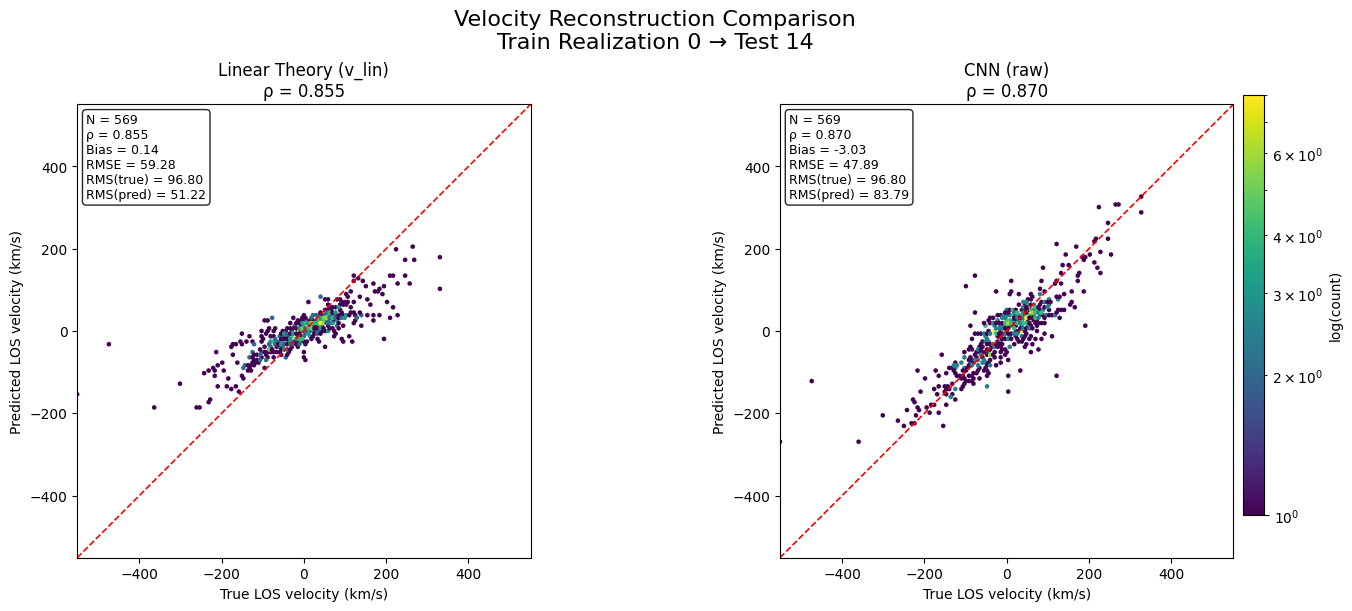

In [16]:
#train_and_eval()